In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.perturbations import *
from src.utils.REPResNet import Bottleneck, REPResNet
from src.utils.REPDataset import REPDataset

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.defences.preprocessor.preprocessor import PreprocessorPyTorch
from art.data_generators import PyTorchDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [3]:
# Step 1: Load the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
num_classes = 100

x_train = trainset.data / 255.0  # Scale pixel values to [0, 1]
y_train = np.array(trainset.targets)

x_test = testset.data / 255.0  # Scale pixel values to [0, 1]
y_test = np.array(testset.targets)

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

y_train = np.eye(num_classes)[y_train].astype(np.float32)
y_test = np.eye(num_classes)[y_test].astype(np.float32)

min_pixel_value = 0.0
max_pixel_value = 1.0

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = torch.from_numpy(x_train).to(device)
y_train = torch.from_numpy(y_train).to(device)

x_test = torch.from_numpy(x_test).to(device)
y_test = torch.from_numpy(y_test).to(device)

In [5]:
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [6]:
train_dataset = SimpleDataset(x_train, y_train)
test_dataset = SimpleDataset(x_test, y_test)

# Testing Round 1

In [7]:
perturbation_tests = [
    [],
    [["Gaussian", 0.025]],
    [["Gaussian", 0.05]],
    [[["Gaussian", 0.05], ["ContrastBrightness", 0.9, 0.9]]],
    [[["Gaussian", 0.05], ["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05], ["SaltPepper", 0.05]]],
    [["Laplacian", 0.025]],
    [["Laplacian", 0.05]],
    [[["Laplacian", 0.05], ["ContrastBrightness", 0.9, 0.9]]],
    [[["Laplacian", 0.05], ["RotationFlip", 0.3]]],
    [[["Laplacian", 0.05], ["SaltPepper", 0.05]]],
    [["Lp-norm", 0.5, 1]],
    [[["Lp-norm", 0.5, 1], ["ContrastBrightness", 0.9, 0.9]]],
    [[["Lp-norm", 0.5, 1], ["RotationFlip", 0.3]]],
    [[["Lp-norm", 0.5, 1], ["SaltPepper", 0.05]]],
    [["Lp-norm", 0.5, 2]],
    [["Lp-norm", 0.5, 3]],
    [["Lp-norm", 0.5, 4]],
    [["Lp-norm", 0.5, float('inf')]],
    [["ContrastBrightness", 0.9, 0.9]],
    [["RotationFlip", 0.3]],
    [["SaltPepper", 0.05]],
    [["Gaussian", 0.05], ["Laplacian", 0.05]],
    [[["Gaussian", 0.05], ["Laplacian", 0.05]]],
    [["Gaussian", 0.05], ["Lp-norm", 0.5, 1]],
    [["Laplacian", 0.05], ["Lp-norm", 0.5, 1]],
    [["Lp-norm", 0.5, 1], ["Lp-norm", 0.5, 2]],
    [["Gaussian", 0.05], ["Laplacian", 0.05], ["Lp-norm", 0.5, 1]],
    [["Gaussian", 0.05], [["Laplacian", 0.05], ["SaltPepper", 0.05]]],
    [["Gaussian", 0.05], [["Lp-norm", 0.5, 1], ["ContrastBrightness", 0.9, 0.9]]],
    [["Laplacian", 0.05], [["Lp-norm", 0.5, 1], ["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05], ["SaltPepper", 0.05]], [["Gaussian", 0.05], ["RotationFlip", 0.3]]],
    [[["Laplacian", 0.05], ["SaltPepper", 0.05]], [["Laplacian", 0.05], ["RotationFlip", 0.3]]],
    [[["Lp-norm", 0.5, 1], ["SaltPepper", 0.05]], [["Lp-norm", 0.5, 1], ["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05], ["SaltPepper", 0.05]], [["Gaussian", 0.05], ["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1], ["SaltPepper", 0.05]], [["Lp-norm", 0.5, 1], ["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05], ["SaltPepper", 0.05]], [["Gaussian", 0.05], ["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1], ["SaltPepper", 0.05]], [["Lp-norm", 0.5, 1], ["RotationFlip", 0.3]], [["Laplacian", 0.05], ["SaltPepper", 0.05]], [["Laplacian", 0.05], ["RotationFlip", 0.3]]]
]
# perturbation_tests = [[["Gaussian", 0.05], ["Laplacian", 0.05]]]

In [8]:
test_history = []

def display_test_history(test_history):
    for i in range(len(test_history)):
        test = test_history[i]
        num_p = len(test['perturbations'])
        io = test['include_original']
        shuffle = test['shuffle']
        training_time = test['training_time']
        baseline = test['baseline_accuracy']
        adversarial = test['adversarial_accuracy']
        adv_str = f"{adversarial[0]*100}/{adversarial[1]*100}/{adversarial[2]*100}/{adversarial[3]*100}"
        print(f"Test {i}: Perturbations ({num_p}), Original ({io}), Shuffle ({shuffle}), Training Time ({training_time}s), Baseline ({baseline*100}%), Adversarial ({adv_str}%)")

In [9]:
from tqdm.auto import tqdm

def train_REPResNet(model, dataset, optimizer, criterion, batch_size, epochs, verbose=True):
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=0)
    for _ in tqdm(range(epochs), disable=not verbose, desc="Epochs"):
        for x_batch, y_batch in dataloader:            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Perform prediction
            model_outputs = model(x_batch)

            y_batch = y_batch.squeeze(1)
            predictions = model_outputs.squeeze(1)
            
            loss = criterion(predictions, y_batch)

            # Do training
            loss.backward()

            optimizer.step()

In [11]:
for perturbation_description in perturbation_tests:
    perturbations = create_perturbations(perturbation_description)
    include_original = perturbation_description == []
    shuffle = True
    multiplicity = len(perturbation_description) + int(include_original)

    # Create REPResNet Model with multiplicity applied
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ## Model is structured after ResNet50
    model = REPResNet(Bottleneck, [3, 4, 5, 3], perturbations, include_original, shuffle,
                       num_classes=num_classes, device=device)

    lr = 0.1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)
    batch_size = 512
    super_epochs = 3
    epochs_per = 10
    
    print(f"Training model with perturbations:")
    print(perturbation_description)

    training_start = time.time()
    for epoch in range(super_epochs):
        train_REPResNet(model, train_dataset, optimizer, criterion, batch_size, epochs_per, True)
        scheduler.step()
        with torch.no_grad():
            train_accuracy = torch.sum(torch.argmax(model(x_train[:1200]), axis=1) == torch.argmax(y_train[:1200], axis=1)) / len(x_train[:1200])
            test_accuracy = torch.sum(torch.argmax(model(x_test[:1200]), axis=1) == torch.argmax(y_test[:1200], axis=1)) / len(x_test[:1200])
            print(f"Epoch {(epoch+1)*epochs_per}/{super_epochs*epochs_per} Complete After {int(time.time() - training_start)}s! Train Acc: {train_accuracy}, Test Acc: {test_accuracy}")
    total_time = time.time() - training_start

    classifier = PyTorchClassifier(
        model=model,
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3*multiplicity, 32, 32),
        nb_classes=num_classes,
    )
    x_test_numpy = x_test.cpu().numpy()
    y_test_numpy = y_test.cpu().numpy()
    with torch.no_grad():
        # Step 5: Evaluate the ART classifier on benign test examples
        predictions = classifier.predict(x_test_numpy)
        baseline_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
        print("Accuracy on benign test examples: {}%".format(baseline_accuracy * 100))

    # Step 6: Generate adversarial test examples
    attack = FastGradientMethod(estimator=classifier, eps=0.025)
    x_test_adv1 = attack.generate(x=x_test_numpy)
    with torch.no_grad():
        predictions = classifier.predict(x_test_adv1)
        adversarial_accuracy1 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
        print("Accuracy on adversarial test examples (epsilon = 0.025): {}%".format(adversarial_accuracy1 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.05)
    x_test_adv2 = attack.generate(x=x_test_numpy)
    with torch.no_grad():
        predictions = classifier.predict(x_test_adv2)
        adversarial_accuracy2 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
        print("Accuracy on adversarial test examples (epsilon = 0.05): {}%".format(adversarial_accuracy2 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.075)
    x_test_adv3 = attack.generate(x=x_test_numpy)
    with torch.no_grad():
        predictions = classifier.predict(x_test_adv3)
        adversarial_accuracy3 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
        print("Accuracy on adversarial test examples (epsilon = 0.075): {}%".format(adversarial_accuracy3 * 100))

    attack = FastGradientMethod(estimator=classifier, eps=0.1)
    x_test_adv4 = attack.generate(x=x_test_numpy)
    with torch.no_grad():
        predictions = classifier.predict(x_test_adv4)
        adversarial_accuracy4 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
        print("Accuracy on adversarial test examples (epsilon = 0.1): {}%".format(adversarial_accuracy4 * 100))

    test_history.append({'model': "REPResNet-50",
                        'layers': [3, 4, 5, 3],
                        'perturbations': perturbation_description,
                        'include_original': include_original,
                        'shuffle': shuffle,
                        'loss': criterion,
                        'lr': lr,
                        'batch_size': batch_size,
                        'epochs': int(super_epochs*epochs_per),
                        'training_time': total_time,
                        'baseline_accuracy': baseline_accuracy,
                        'adversarial_accuracy': [adversarial_accuracy1, adversarial_accuracy2, adversarial_accuracy3, adversarial_accuracy4]})

Training model with perturbations:
[]


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/30 Complete After 1975s! Train Acc: 0.14750000834465027, Test Acc: 0.125


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
display_test_history(test_history=test_history)

Test 0: Perturbations (0), Original (True), Shuffle (True), Training Time (350.0729911327362s), Baseline (75.46000000000001%), Adversarial (19.939999999999998/14.27/13.139999999999999/12.16%)
Test 1: Perturbations (1), Original (False), Shuffle (True), Training Time (352.46080446243286s), Baseline (74.15%), Adversarial (23.89/15.479999999999999/14.27/13.07%)
Test 2: Perturbations (1), Original (False), Shuffle (True), Training Time (346.91450667381287s), Baseline (74.65%), Adversarial (29.220000000000002/16.59/14.41/13.07%)
Test 3: Perturbations (1), Original (False), Shuffle (True), Training Time (347.00770258903503s), Baseline (20.89%), Adversarial (13.94/10.0/17.349999999999998/19.939999999999998%)
Test 4: Perturbations (1), Original (False), Shuffle (True), Training Time (346.6512551307678s), Baseline (70.34%), Adversarial (22.939999999999998/61.41/37.419999999999995/55.71%)
Test 5: Perturbations (1), Original (False), Shuffle (True), Training Time (347.29287457466125s), Baseline (

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


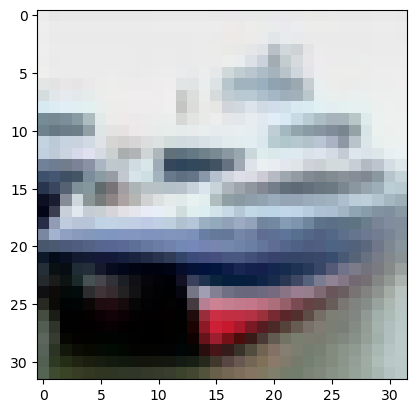

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


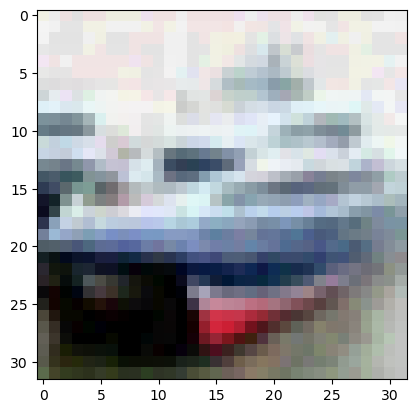

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


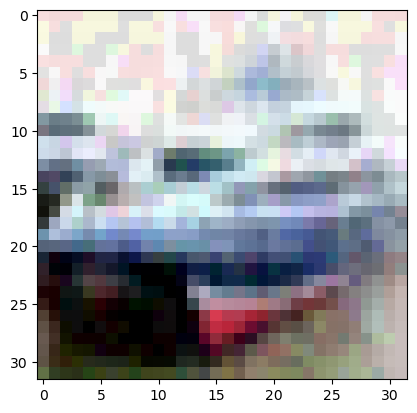

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


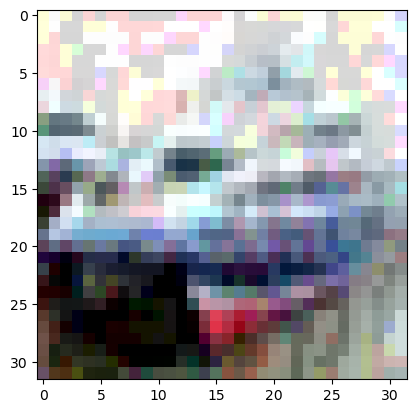

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


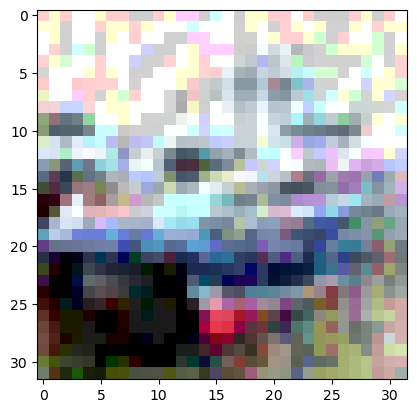

In [22]:
idx = 1
print(y_test[idx])

plt.figure()
plt.imshow(np.transpose(x_test[idx], (1, 2, 0)))
plt.show()

plt.figure()
plt.imshow(np.transpose(x_test_adv1[idx], (1, 2, 0)))
plt.show()

plt.figure()
plt.imshow(np.transpose(x_test_adv2[idx], (1, 2, 0)))
plt.show()

plt.figure()
plt.imshow(np.transpose(x_test_adv3[idx], (1, 2, 0)))
plt.show()

plt.figure()
plt.imshow(np.transpose(x_test_adv4[idx], (1, 2, 0)))
plt.show()

In [9]:
import csv

def save_to_csv(data, filename):
    if not data:
        return

    # Extract the keys from the first dictionary as headers
    headers = list(data[0].keys())

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)

        # Write the headers
        writer.writeheader()

        # Write each dictionary as a row in the CSV file
        for item in data:
            writer.writerow(item)

    print(f"Data saved to {filename} successfully.")

save_to_csv(test_history, ROOT + "notebooks/experiment_log/cifar_10_resnet_round_1_training_results.csv")

Data saved to ../../notebooks/experiment_log/cifar_10_resnet_round_1_training_results.csv successfully.
